In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from simple_hierarchical_topic_model import SimpleHierarchicalTopicModel

In [3]:
np.random.seed(1)

In [4]:
class SimData(object):
    '''Generate a simulated dataset'''
    def __init__(self, num_leaves):
        self.num_leaves = num_leaves
        self.num_depths = 2
        self.vocab_size = self.num_leaves * 2 + 6
        self.num_docs = 1000
        self.doc_length = 100
        self.vocab = ["w{}".format(i) for i in range(self.vocab_size)]
        self.alpha_leaves = 100.0 * np.ones((self.num_leaves,))
        self.alpha_depths = 100.0 * np.ones((2,))
        self.init_topics()

    def init_topics(self):
        self.nodes = [()] + [(i,) for i in range(self.num_leaves)]
        self.topics_by_path = dict()
        self.topics_by_index = []
        for node_index, path in enumerate(self.nodes):
            current_topic = np.ones(self.vocab_size)
            heavy_vocab_indices = slice(node_index * 2, (node_index + 1) * 2)
            current_topic[heavy_vocab_indices] *= 1000
            current_topic /= current_topic.sum()
            self.topics_by_path[path] = current_topic
            self.topics_by_index.append(current_topic)
        self.topics_by_index = np.stack(self.topics_by_index)

    def generate(self):
        self.docs = []
        self.docs_aux = []

        for i in range(self.num_docs):
            leaf_distrib = np.random.dirichlet(self.alpha_leaves)
            depth_distrib = np.random.dirichlet(self.alpha_depths)
            node_distrib = np.concatenate([[depth_distrib[0]], depth_distrib[1] * leaf_distrib])
            current_node_indices = np.random.choice(len(self.nodes), size = self.doc_length, p = node_distrib)
            current_doc = []
            for j in range(self.doc_length):
                topic = self.topics_by_index[current_node_indices[j]]
                word_index = np.random.choice(self.vocab_size, p = topic)
                current_doc.append(self.vocab[word_index])
            current_doc = " ".join(current_doc)
            self.docs.append(current_doc)
            self.docs_aux.append({
                "doc": current_doc,
                "leaf_distrib": leaf_distrib,
                "depth_distrib": depth_distrib,
                "node_distrib": node_distrib,
                "node_indices_by_word_slot": current_node_indices,
            })

        return self.docs

    def custom_initializer(self):
        result = dict()
        result["L"] = np.ones((self.num_docs * self.doc_length, self.num_leaves))
        result["D"] = np.ones((self.num_docs * self.doc_length, self.num_depths))
        result["DL"] = np.broadcast_to(self.alpha_leaves, (self.num_docs, self.num_leaves))
        result["DD"] = np.broadcast_to(self.alpha_depths, (self.num_docs, self.num_depths))
        result["DV"] = self.topics_by_index / np.min(self.topics_by_index)
        return result

In [5]:
%%time
sim = SimData(num_leaves = 2)
docs = sim.generate()

CPU times: user 2.47 s, sys: 19.8 ms, total: 2.49 s
Wall time: 2.51 s


In [6]:
import os
import sys
sys.path.append(os.path.abspath(".."))
import text_utils

In [7]:
%%time
data, vocab = text_utils.document_strings_to_sparse_term_doc(
    docs = docs,
    tokenizer = text_utils.default_tokenizer,
    vocab = sim.vocab)

CPU times: user 2.34 s, sys: 6.2 ms, total: 2.34 s
Wall time: 2.34 s


In [8]:
vocab

['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']

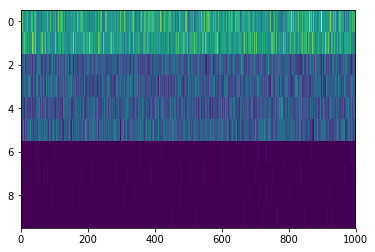

In [9]:
plt.imshow(data.todense(), aspect='auto');

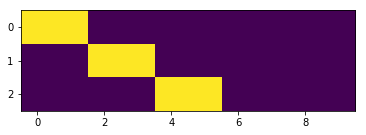

In [10]:
plt.imshow(sim.topics_by_index);

In [11]:
model = SimpleHierarchicalTopicModel(
    branching_factors = [sim.num_leaves], num_epochs = 100,
    batch_size = None, vocab = vocab,
    save_params_history = True,
    update_order = ["D", "L", "DD", "DL", "DV", ])

In [12]:
model.fit(data)
top_words = model.get_top_words_by_node(num_words = 10)
model.print_top_words_by_node(num_words = 10);

100%|██████████| 100000/100000 [00:39<00:00, 2630.46it/s, Status=computing statistics]

Top words by node:
()  : w0, w4, w1, w5, w3, w2, w9, w7, w6, w8
(0,): w1, w0, w2, w3, w5, w4, w8, w7, w6, w9
(1,): w1, w0, w2, w3, w5, w4, w8, w7, w6, w9


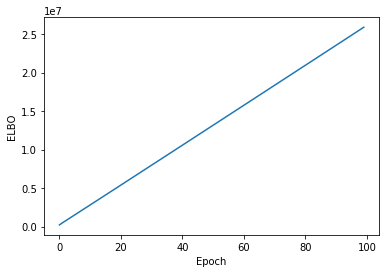

In [13]:
fig, ax = plt.subplots()
ax.plot(model.get_stats_by_epoch("epoch_index"), model.get_stats_by_epoch("ELBO"))
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO")
None

In [14]:
var_params = dict()
for name in ["DL", "DD", "DV", "L", "D"]:
    var_params[name] = model.get_stats_by_epoch("var_params_" + name)
epoch_indices = model.get_stats_by_epoch("epoch_index")

In [15]:
for k, v in var_params.items():
    print("{:2}: {}".format(k, v.shape))

DL: (101, 1000, 2)
DV: (101, 3, 10)
D : (101, 100000, 2)
DD: (101, 1000, 2)
L : (101, 100000, 2)


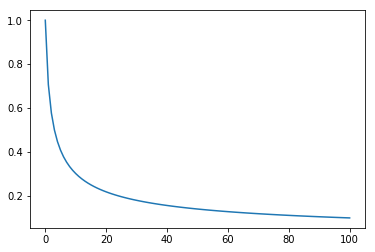

In [16]:
plt.plot(model.get_stats_by_epoch("step_size"));

In [17]:
def mean_dirichlet(X, axis = -1):
    return X / X.sum(axis = axis, keepdims = True)

In [18]:
def norm_variance_dirichlet(X, axis = -1):
    a0 = X.sum(axis = axis, keepdims = True)
    variance = X * (a0 - X) / (a0 ** 2 * (a0 + 1.0))
    norm_variance = np.linalg.norm(variance, axis = axis)
    return norm_variance

In [19]:
def mean_discrete(p, axis = -1, keepdims = False):
    axis = axis if axis >= 0 else len(p.shape) + axis
    values_target_shape = [1 if i != axis else p.shape[axis] for i in range(len(p.shape))]
    values = np.arange(p.shape[axis]).reshape(values_target_shape)
    values, p = np.broadcast_arrays(values, p)
    return np.sum(values * p, axis = axis, keepdims = keepdims)

In [20]:
def variance_discrete(p, axis = -1):
    axis = axis if axis >= 0 else len(p.shape) + axis
    values_target_shape = [1 if i != axis else p.shape[axis] for i in range(len(p.shape))]
    values = np.arange(p.shape[axis]).reshape(values_target_shape)
    values, p = np.broadcast_arrays(values, p)
    zzz = np.sum((values ** 2) * p, axis = axis)
    mean_sq = mean_discrete(p, axis = axis) ** 2
    return zzz - mean_sq

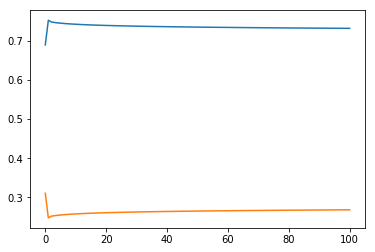

In [21]:
plt.plot(mean_dirichlet(var_params["DL"][:, 0, :]));

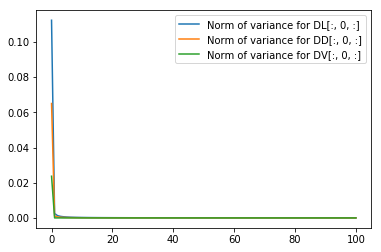

In [22]:
fig, ax = plt.subplots()
for name in ["DL", "DD", "DV"]:
    ax.plot(norm_variance_dirichlet(var_params[name][:, 0, :]),
        label = "Norm of variance for {}[:, 0, :]".format(name))
ax.legend(loc='best')
None

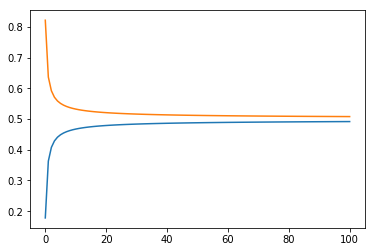

In [23]:
plt.plot(mean_dirichlet(var_params["DD"][:, 0, :]));

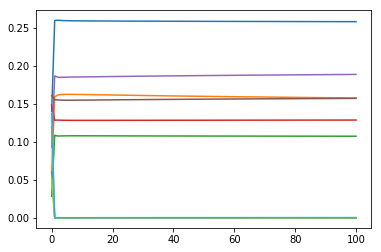

In [24]:
plt.plot(mean_dirichlet(var_params["DV"][:, 0, :]));

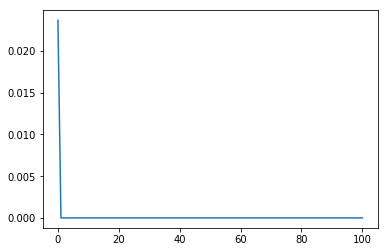

In [25]:
zzz = norm_variance_dirichlet(var_params["DV"][:, 0, :])
plt.plot(zzz);

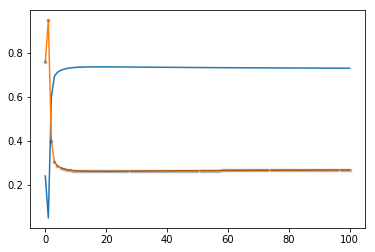

In [26]:
plt.plot(var_params["L"][:, 0, :]);
plt.plot(mean_discrete(var_params["L"][:, 0, :]), 'k.', alpha=0.2);

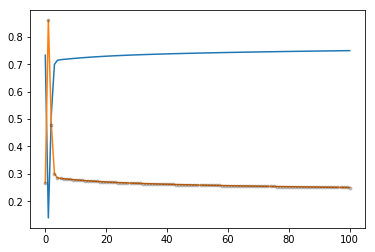

In [27]:
plt.plot(var_params["D"][:, 0, :]);
plt.plot(mean_discrete(var_params["D"][:, 0, :]), 'k.', alpha=0.2);

In [28]:
topic_vectors = model.get_expected_topic_vectors()

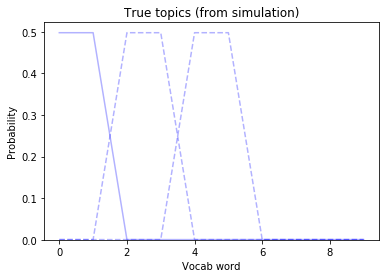

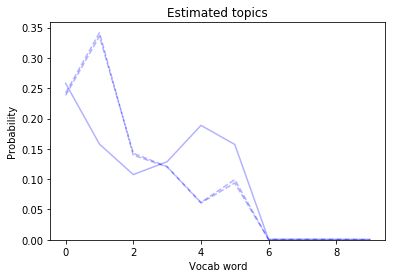

In [29]:
fig, ax = zip(*[plt.subplots() for i in range(2)])
for i in range(len(sim.nodes)):
    linestyle = '-' if i == 0 else '--'
    ax[0].plot(sim.topics_by_index[i,:], color='b', linestyle=linestyle, alpha=0.3)
    ax[1].plot(topic_vectors[i,:], color='b', linestyle=linestyle, alpha=0.3)
ax[0].set_title("True topics (from simulation)")
ax[1].set_title("Estimated topics")
for a in ax:
    a.set_xlabel("Vocab word")
    a.set_ylabel("Probability")
    a.set_ylim(0, None)
None

In [30]:
# Compare topic vectors to mean_dirichlet of most recent DV params (values should match)
zzz = mean_dirichlet(model.get_stats_by_epoch("var_params_DV")[-1, :, :])
np.linalg.norm(topic_vectors - zzz)

0.0